In [28]:
import pandas as pd
import numpy as np
import ast
from collections import Counter, OrderedDict
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from utilities import *
from music21.harmony import chordSymbolFigureFromChord as figureChord
from music21.chord import Chord

from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.python.keras.layers.embeddings import Embedding
from tensorflow.keras.preprocessing import sequence

import warnings

warnings.filterwarnings(action="once")

LSTM requirements:

- The LSTM input layer must be 3D.
- LSTMs don’t like sequences of more than 200-400 time steps, so the data will need to be split into samples.
- If you have a long sequence of thousands of observations, you must split it into samples and then reshape it for your LSTM model.
- The LSTM needs data with the format of [samples, time steps and features].
- The LSTM input layer is defined by the input_shape argument on the first hidden layer.
- The input_shape argument takes a tuple of two values that define the number of time steps and features.
- The number of samples is assumed to be 1 or more.
- The reshape() function on NumPy arrays can be used to reshape your 1D or 2D data to be 3D.
- The reshape() function takes a tuple as an argument that defines the new shape.


In [2]:
from gensim.models import Word2Vec
from gensim.models.fasttext import FastText
import utilities as my_utils
ft = FastText.load("./embeddings/fastText.model")
songs = my_utils.build_sentences()

C:\Users\Mateusz\Miniconda3\envs\tf-gpu-env\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\Mateusz\Miniconda3\envs\tf-gpu-env\lib\site-packages\gensim\corpora\dictionary.py:11: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, defaultdict
C:\Users\Mateusz\Miniconda3\envs\tf-gpu-env\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
C:\Users\Mateusz\Miniconda3\envs\tf-gpu-env\lib\site-packages\gensim\models\doc2vec.py:73: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 i

In [4]:
def prep_data(songs, sample_len = 4):
    # Remove too short songs
    songs = [chords for chords in songs if len(chords) > sample_len]
    x = []
    y = []
    for chords in songs:
        for i in range(len(chords)):
            if i < len(chords) - sample_len:
                x.append(chords[i: i + sample_len - 1])
            else:
                x.append(
                    chords[i: len(chords) - 1]
                    + chords[: (i + sample_len) % len(chords)]
                )
            y.append(chords[(i + sample_len) % len(chords)])
    x = np.array(x)
    y = np.array(y)
    print(x.shape, y.shape)
    return x, y

X, y = prep_data(songs)

(1243944, 3) (1243944,)


In [12]:
from tqdm import tqdm_notebook as tqdm
def encode_chords(X, y, model):
    X_embedded = []
    y_embedded = []
    for X_sample, y_sample in tqdm(zip(X, y), total=X.shape[0], desc=str(model).split("(")[0]+' Encoding'):
        X_embedded.append(model.wv[X_sample])
        y_embedded.append(model.wv[y_sample])
    X_embedded = np.array(X_embedded)
    y_embedded = np.array(y_embedded)
    return X_embedded, y_embedded

X_embedded, y_embedded = encode_chords(X, y, ft)

In [10]:
print(y_embedded[0])

[-2.8218837   2.6679103   1.1131471  -1.3137835  -0.1720473   0.6520036
  0.5008011  -1.3545598  -1.2499863   0.53334844  0.4341415  -0.02315862
  1.7414213  -0.3618903  -2.1168952   1.6319815  -1.4610413   0.5977253
 -0.45896897  0.80857223  0.89994234  3.2679656   0.75783396 -2.9877284
  0.79341704 -0.14857055 -0.98599106 -0.327897    1.6920537  -0.75195116
 -0.22168867  0.95694226  1.5130386  -1.2832272   0.33268866  1.0442535
 -1.9442675  -1.6550491  -0.05510071 -0.47213438  0.30764127 -0.30558968
 -0.3758615   0.75716263 -1.0502764  -1.1331551   1.2711804  -2.2275395
  2.4989285  -2.1432517   0.85097796  0.2423095   1.6097819   1.6056014
 -1.3808945   1.0785171   0.16974561 -1.024235   -0.44757247  0.03198034
  1.1975018   2.1273863   0.23836027 -2.0223749 ]


In [145]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_embedded, y_embedded, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0)
for name, X_set in zip(["Train", "Test", "Valid"],[X_train, X_test, X_val]):
    print(name,":\t", round(X_set.shape[0]/X_embedded.shape[0]*100),"%", sep="")

Train:	60%
Test:	20%
Valid:	20%


# Test Model

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense, Dropout

model = keras.Sequential(
    [
        LSTM(64, input_shape=X_train.shape[1:]),
        Dense(y_train.shape[1], activation='sigmoid')
    ]
)

In [146]:

class Metrics(Callback):
    def __init__(embedding):
        self.embedding = embedding
        
    def on_train_begin(self, logs={}):
        self._data = []

    def on_epoch_end(self, batch, logs={}):
        X_val, y_val = self.validation_data[0], self.validation_data[1]
        y_predict = np.asarray(model.predict(X_val))

        y_val = np.argmax(y_val, axis=1)
        y_predict = np.argmax(y_predict, axis=1)

        self._data.append({
            'val_rocauc': roc_auc_score(y_val, y_predict),
        })
        return

    def get_data(self):
        return self._data


In [153]:
X_train.shape[1:]

(3, 64)

In [277]:
model = Sequential(
    [
        LSTM(128, activation='relu', return_sequences=True, input_shape=X_train.shape[1:]),
        LSTM(128),
        Dense(y_train.shape[1])
    ]
)

In [374]:
import tensorflow
import tensorflow.keras.backend as K
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC
from tensorflow.keras.losses import MeanSquaredError, Huber
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import Callback

from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix

class Metrics(Callback):
    def __init__(self, tr_data, val_data):
        self.validation_data = val_data    
        self.train_data = tr_data    
    
    def cosine_distance_sum(A, B):
        return sum([1.0 - np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b)) for a,b in zip(A, B)])

    def mean_cos_dist(X_vali, y_vali):
        y_pred = model.predict(X_vali)
        return cosine_distance_sum(y_pred, y_vali)/y_vali.shape[0]
        
    def on_train_begin(self, logs={}):
        self.mean_cos_dist = []      
        self.val_mean_cos_dist = []       
        
    def on_epoch_end(self, epoch, logs={}):
        score = mean_cos_dist(self.train_data[0][:1000], self.train_data[1][:1000])
        score_val = mean_cos_dist(self.validation_data[0][:1000], self.validation_data[1][:1000])
        self.mean_cos_dist.append(score)
        self.val_mean_cos_dist.append(score_val)
        print('epoch {},\tloss {:3.4f},\tval_loss {:3.4f}\tmean_cos_dist {:3.4f}\tval_mean_cos_dist {:3.4f}.'.format(
            epoch, logs['loss'], logs['val_loss'], score, score_val))
        
    def on_train_end(self, logs={}):
        self.mean_cos_dist = {'mean_cos_dist': self.mean_cos_dist}    
        self.val_mean_cos_dist = {'val_mean_cos_dist': self.val_mean_cos_dist}      
        
    def get_train_data(self):
        return self.train_data
    
    def get_val_data(self):
        return self.validation_data
    
    
validation_split = 0.25
epochs = 10
batch_size = 5000
loss = Huber() 
optimizer = Adam(lr=1e-3)
metrics = Metrics((X_train, y_train),
                  (X_val, y_val))

METRICS_NAMES = [
        "loss",
        "mean_cos_dist",
    ]
model.compile(loss=loss, batch_size=batch_size, optimizer=optimizer)
print(model.summary())
history = model.fit(metrics.get_train_data()[0], 
                    metrics.get_train_data()[1], 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_data = metrics.get_val_data(),
                    callbacks=[metrics], 
                    verbose=1).history

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 3, 128)            98816     
_________________________________________________________________
lstm_23 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
Total params: 238,656
Trainable params: 238,656
Non-trainable params: 0
_________________________________________________________________
None
Train on 746366 samples, validate on 248789 samples
Epoch 1/10
746366/746366 [==============================] - 11s 15us/sample - loss: 0.5166 - val_loss: 0.5236
Epoch 2/10
746366/746366 [==============================] - 7s 9us/sample - loss: 0.5046 - val_loss: 0.5172
Epoch 3/10
746366/746366 [==============================] - 7s 9us/sample - loss: 0.5001 - val_loss: 0

In [375]:
import matplotlib.pyplot as plt
def plot_loss(history, metric_name):
    val_loss = history["val_" + metric_name]
    plt.plot(val_loss, linewidth=3, label="valid")
    loss = history[metric_name]
    plt.plot(loss, linewidth=3, label="train")
    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel(metric_name)
    plt.title(metric_name)
    plt.show()

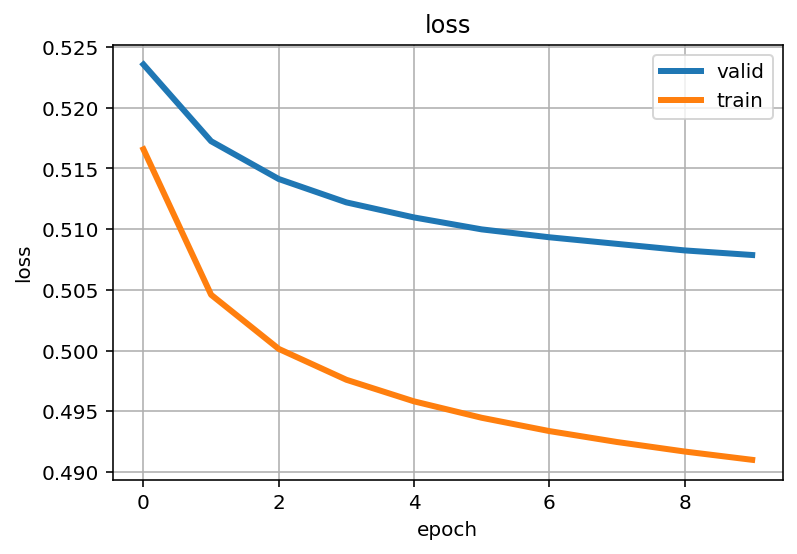

KeyError: 'val_mean_cos_dist'

In [376]:
for metric_name in METRICS_NAMES:
    plot_loss(history, metric_name)

In [167]:
print(X_train[0][0], ft.wv.most_similar(X_train[0][0].reshape(1,-1))[0], sep="\n")

[ 0.2831416   1.9003518  -0.5969981   0.04515171  0.88170296 -1.8052266
 -0.28070796 -0.7344635  -0.5129904   0.5274376  -0.50100714  0.35816643
 -0.50922704 -1.9544994   0.02911769  1.1419986   0.01741598  0.5366339
 -1.4860406   0.5877922  -0.6481257   1.7070045  -0.65793806  1.18562
  0.46790358 -0.45111388  0.16563676 -2.42333    -0.20980245  0.73004264
  0.1077087  -0.0410464  -1.8511068  -0.4033527   0.5019449   1.9654834
 -0.8074281  -0.7183717  -0.638709    1.6402546   1.4586475  -0.3450368
 -0.8329103  -0.53891575 -0.8557045   0.56288075 -0.14011712 -0.19686495
 -1.7863393   0.06247514  0.5551195  -1.4328742   1.5419097  -0.2912826
 -1.1314827   0.41545781 -0.6453534   0.49623677 -0.38735077 -1.5992879
  1.1138496  -1.2525398  -0.26182267 -0.30861476]
('Dbo7', 1.0000001192092896)


In [168]:
X_test[0][np.newaxis, :].shape, X_test[0:1].shape

((1, 3, 64), (1, 3, 64))

In [191]:
y_pred = model.predict(X_val)

In [215]:
y_pred[0]

array([1.1765480e-02, 9.9932218e-01, 1.5053064e-02, 7.3697269e-02,
       4.1568816e-02, 1.0145307e-03, 6.9227779e-01, 2.7146310e-02,
       5.6087404e-02, 9.8156953e-01, 4.1623086e-02, 1.7766654e-03,
       9.5526654e-01, 9.5456839e-05, 2.1044910e-03, 9.9726462e-01,
       7.9795456e-01, 9.8848116e-01, 8.7758899e-04, 6.7255825e-02,
       5.6697845e-01, 2.6142174e-01, 8.3818436e-03, 1.0466874e-03,
       2.1749616e-02, 3.7980625e-01, 3.8614780e-01, 6.4440370e-03,
       7.0753086e-01, 4.0321946e-03, 1.1001676e-02, 8.2796770e-01,
       6.9072545e-03, 2.1427870e-04, 7.9796612e-03, 2.6754647e-02,
       1.3144612e-03, 3.3476949e-04, 1.1012545e-01, 1.6420603e-02,
       5.2706182e-01, 1.2637675e-03, 1.8366277e-03, 2.0543215e-01,
       3.6429465e-03, 7.7060550e-02, 3.3498409e-01, 9.8288864e-02,
       2.8477907e-03, 6.0220957e-03, 7.2938544e-01, 1.6391873e-03,
       8.9170790e-01, 4.8121333e-02, 2.4847984e-03, 9.5821273e-01,
       3.2187700e-03, 1.6988397e-02, 1.8121332e-02, 6.6918099e

In [240]:
for i in range(20):
    print(ft.wv.most_similar(y_test[i].reshape(1,-1))[0][0] in [d[0] for d in ft.wv.most_similar(y_pred)][:10], end="\t")
    print(ft.wv.most_similar(x_test_ex[0].reshape(1,-1))[0][0], end="\t")
    print(ft.wv.most_similar(x_test_ex[1].reshape(1,-1))[0][0], end="\t")
    print(ft.wv.most_similar(x_test_ex[2].reshape(1,-1))[0][0], end="\t")
    print("(", ft.wv.most_similar(y_test[i].reshape(1,-1))[0][0], end=" )\t")
    print([d[0] for d in ft.wv.most_similar(y_pred)][:10])

False	C	D7	D7	( B-7 )	['Db7', 'Ab-7', 'Gb7', 'Eb7', 'Ab7', 'C-7', 'Bbh7', 'Ab-', 'Bb7', 'Ab^7']
False	C	D7	D7	( B )	['Db7', 'Ab-7', 'Gb7', 'Eb7', 'Ab7', 'C-7', 'Bbh7', 'Ab-', 'Bb7', 'Ab^7']
False	C	D7	D7	( Eb7sus )	['Db7', 'Ab-7', 'Gb7', 'Eb7', 'Ab7', 'C-7', 'Bbh7', 'Ab-', 'Bb7', 'Ab^7']
True	C	D7	D7	( Db7 )	['Db7', 'Ab-7', 'Gb7', 'Eb7', 'Ab7', 'C-7', 'Bbh7', 'Ab-', 'Bb7', 'Ab^7']
False	C	D7	D7	( B7 )	['Db7', 'Ab-7', 'Gb7', 'Eb7', 'Ab7', 'C-7', 'Bbh7', 'Ab-', 'Bb7', 'Ab^7']
False	C	D7	D7	( F7 )	['Db7', 'Ab-7', 'Gb7', 'Eb7', 'Ab7', 'C-7', 'Bbh7', 'Ab-', 'Bb7', 'Ab^7']
False	C	D7	D7	( C6 )	['Db7', 'Ab-7', 'Gb7', 'Eb7', 'Ab7', 'C-7', 'Bbh7', 'Ab-', 'Bb7', 'Ab^7']
False	C	D7	D7	( D7 )	['Db7', 'Ab-7', 'Gb7', 'Eb7', 'Ab7', 'C-7', 'Bbh7', 'Ab-', 'Bb7', 'Ab^7']
False	C	D7	D7	( Bb^7 )	['Db7', 'Ab-7', 'Gb7', 'Eb7', 'Ab7', 'C-7', 'Bbh7', 'Ab-', 'Bb7', 'Ab^7']
False	C	D7	D7	( A7 )	['Db7', 'Ab-7', 'Gb7', 'Eb7', 'Ab7', 'C-7', 'Bbh7', 'Ab-', 'Bb7', 'Ab^7']
False	C	D7	D7	( D7 )	['Db7', 'Ab-7', 'Gb7', 

In [10]:
for i in range(20):
    predict_chords(loaded_model, X_test[i])

A-maj7/C  | A#m7/C#  | A-maj7/C  | Fm7/C
Fm/C  | Fm/C  | C7  | Fm/CaddB-
Gm/D  | B-7/D  | Fm/C  | Gm7/D
E-  | A-7/C  | A-7/C  | A-/CaddA
Gm7/D  | C7  | F/C  | F/CaddB-
E-  | Gm/D  | Cm  | Cm7
C7  | F-+/CaddB-  | F/C  | B-/C
B-/D  | E-+  | C7  | Chord Symbol Cannot Be Identified
F7/C  | B-/D  | B-/D  | B-/C
E-m  | A#m7/C#  | E-m  | Chord Symbol Cannot Be Identified
Gm7/D  | C7  | F/C  | B-/C
D/o7/C  | E-+addF  | Cm7  | B-/C
F9/CaddB  | B-7/D  | Cm7addD-,A-,F  | D-maj7/C
A7/C#  | D7/C  | D7/C  | Chord Symbol Cannot Be Identified
Fm7/C  | B-7/D  | E-maj7/D  | D/o7/C
Am7/C  | E7/D  | E7/D  | CaddD
B-7/D  | E-maj7/D  | B-/D  | Cm7
B-/D  | A7/C#  | B-/D  | E-addF
Gm7/D  | Gm7/D  | Cm7  | B-/C
A7/C#  | Dm  | G7/D  | Chord Symbol Cannot Be Identified
